In [37]:
from lib.data import UnhealthyMegaPlantDataset
from lib.config import Directories
from PIL import Image
from torchvision import transforms
import json

import seaborn as sns
import matplotlib.pyplot as plt
from iragca.matplotlib import Styles
from lib.config import Directories

plt.style.use(Styles.ML.value)

IMAGE_SIZE = (32, 32)
transform_pipeline = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = UnhealthyMegaPlantDataset(data_path=Directories.INTERIM_DATA_DIR.value / "leaves", transforms=transform_pipeline)

In [9]:
from collections import defaultdict


freq_table = defaultdict(int)
for sample, label in dataset:
    freq_table[label] += 1

<Axes: >

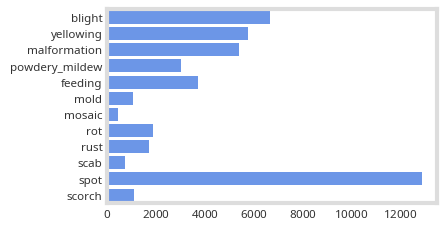

In [13]:
symptom_int_map = {v: k for k, v in dataset.SYMPTOM_MAP.items()}
sns.barplot(y=[symptom_int_map[i] for i in freq_table.keys()], x=list(freq_table.values()), orient='h')

In [33]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, channels: int, output_dim: int = 1):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [34]:
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 32

train_data, val_data, test_data = random_split(dataset, [0.7, 0.2, 0.1])

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [ ]:
for sample, label in train_loader:
    print(sample.shape, label.shape)
    print(sample, label)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])
tensor([[[[0.5137, 0.5216, 0.5176,  ..., 0.4745, 0.4706, 0.4706],
          [0.5137, 0.5137, 0.5098,  ..., 0.4706, 0.4745, 0.4706],
          [0.5098, 0.4980, 0.4980,  ..., 0.4745, 0.4706, 0.4706],
          ...,
          [0.3922, 0.4000, 0.4000,  ..., 0.3569, 0.3569, 0.3647],
          [0.4000, 0.4157, 0.4157,  ..., 0.3647, 0.3686, 0.3686],
          [0.3961, 0.4039, 0.4118,  ..., 0.3686, 0.3647, 0.3608]],

         [[0.5176, 0.5255, 0.5216,  ..., 0.4941, 0.4902, 0.4902],
          [0.5176, 0.5176, 0.5137,  ..., 0.4902, 0.4941, 0.4902],
          [0.5137, 0.5020, 0.5020,  ..., 0.4980, 0.4902, 0.4902],
          ...,
          [0.3843, 0.3922, 0.3961,  ..., 0.3647, 0.3647, 0.3725],
          [0.3922, 0.4078, 0.4078,  ..., 0.3647, 0.3725, 0.3725],
          [0.3882, 0.3961, 0.4039,  ..., 0.3686, 0.3647, 0.3608]],

         [[0.5255, 0.5333, 0.5294,  ..., 0.5059, 0.5020, 0.5020],
          [0.5255, 0.5255, 0.5216,  ..., 0.5020, 0.5020, 0.5020

In [23]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from iragca.ml import RunLogger
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import f1_score, accuracy_score

model = SimpleCNN(channels=3, output_dim=len(dataset.SYMPTOM_MAP))
optimizer = SGD(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
EPOCHS = 50
THRESHOLD = 0.5

def train(model, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=True, 
        unit="epoch", 
        desc="Epochs"
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        train_preds, train_targets = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_pred = outputs.argmax(dim=1).cpu().numpy()
            train_target = targets.cpu().numpy()
            train_preds.extend(train_pred)
            train_targets.extend(train_target)

        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_preds, val_targets = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_pred = outputs.argmax(dim=1).cpu().numpy()
                val_target = targets.cpu().numpy()
                val_preds.extend(val_pred)
                val_targets.extend(val_target)

            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')
            val_acc = accuracy_score(val_targets, val_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_f1': train_f1,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_f1': val_f1,
            'val_acc': val_acc,
            }, epoch)

    return logger

logger = train(model, optimizer, criterion, epochs=EPOCHS)

Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Training:   0%|          | 0/969 [00:00<?, ?it/s]

Validating:   0%|          | 0/277 [00:00<?, ?it/s]

Text(0.5, 1.0, 'F1 Score over Epochs')

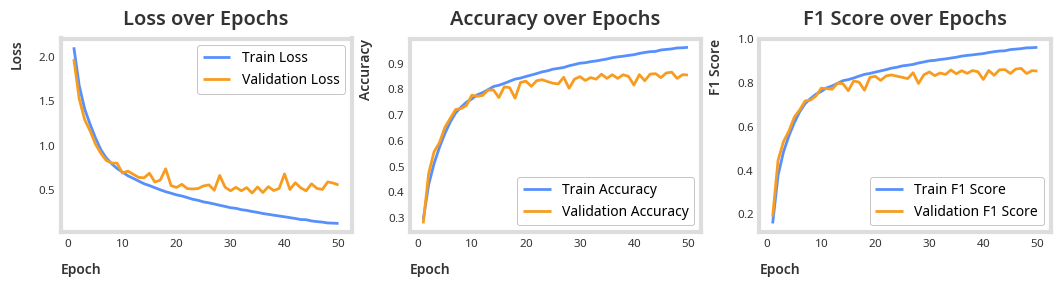

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))

sns.lineplot(x=logger.steps, y=logger.train_loss, label='Train Loss', ax=ax[0])
sns.lineplot(x=logger.steps, y=logger.val_loss, label='Validation Loss', ax=ax[0])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss over Epochs')

sns.lineplot(x=logger.steps, y=logger.train_acc, label='Train Accuracy', ax=ax[1])
sns.lineplot(x=logger.steps, y=logger.val_acc, label='Validation Accuracy', ax=ax[1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy over Epochs')

sns.lineplot(x=logger.steps, y=logger.train_f1, label='Train F1 Score', ax=ax[2])
sns.lineplot(x=logger.steps, y=logger.val_f1, label='Validation F1 Score', ax=ax[2])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('F1 Score')
ax[2].set_title('F1 Score over Epochs')

In [38]:
torch.save(model.state_dict(), Directories.MODELS_DIR.value / "symptom_identification_model.pth")

with open(Directories.MODELS_DIR.value / "symptom_identification_model_train_results.json", "w") as f:
    json.dump(logger.get_logs(), f)

In [ ]:
model = SimpleCNN(channels=3, output_dim=len(dataset.SYMPTOM_MAP))

with open(Directories.MODELS_DIR.value / "symptom_identification_model_train_results.json", "w") as f:
    json.dump(logger.get_logs(), f)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.SimpleCNN was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.SimpleCNN])` or the `torch.serialization.safe_globals([__main__.SimpleCNN])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.